In [1]:
import os
import shutil
import utilities as rocku
import matplotlib.pyplot as plt
import tomopy
import numpy as np
import pandas as pd
import pprint
import dxchange
from pystackreg import StackReg
import multiprocessing as mp
import timeit
from tqdm import tqdm
ncore = mp.cpu_count()
print("CPU cores:", ncore)

CPU cores: 64


In [2]:
# need to change
ipts="33285"
# scan_type = 'ct_scans'
scan_type = 'radiographs'
# scan_type = 'alignment_calibration'

In [88]:
scan_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/" + scan_type
sorted(os.listdir(scan_loc))

['2024_09_24_AG_1',
 '2024_09_24_IL_1',
 '2024_09_24_Shale_S8_1',
 '2024_09_26_AG1_2',
 '2024_09_26_AG2']

In [4]:
ob_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/ob"
sorted(os.listdir(ob_loc))

['2024_09_24_30s']

In [5]:
dc_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/dc"
sorted(os.listdir(dc_loc))

['2024_09_24_30s']

In [111]:
###################### need to change start
sample_name = "2024_09_26_AG1_2"
scan_dir = os.path.join(scan_loc, sample_name)
ob_dir = os.path.join(ob_loc, "2024_09_24_30s")
dc_dir = os.path.join(dc_loc, "2024_09_24_30s")
# ct_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
# ob_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
# dc_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
ob_name = "*OB*" # Will not be used if follows the default file structure
dc_name = "*DC*" # Will not be used if follows the default file structure
gamma_diff = 20
###################### need to change end

# Preprocess scan files

In [112]:
fname_list = os.listdir(scan_dir)
# fname_list.pop(0)
fname_list.sort()
print(len(fname_list))
fname_list

129


['scan_AG1_2_100psi_0030_2168.tiff',
 'scan_AG1_2_100psi_0030_2169.tiff',
 'scan_AG1_2_100psi_0030_2170.tiff',
 'scan_AG1_2_100psi_0030_2171.tiff',
 'scan_AG1_2_100psi_0030_2172.tiff',
 'scan_AG1_2_100psi_0030_2173.tiff',
 'scan_AG1_2_100psi_0030_2174.tiff',
 'scan_AG1_2_100psi_0030_2175.tiff',
 'scan_AG1_2_100psi_0030_2176.tiff',
 'scan_AG1_2_100psi_0030_2177.tiff',
 'scan_AG1_2_100psi_0030_2178.tiff',
 'scan_AG1_2_100psi_0030_2179.tiff',
 'scan_AG1_2_100psi_0030_2180.tiff',
 'scan_AG1_2_100psi_0030_2181.tiff',
 'scan_AG1_2_100psi_0030_2182.tiff',
 'scan_AG1_2_100psi_0030_2183.tiff',
 'scan_AG1_2_100psi_0030_2184.tiff',
 'scan_AG1_2_100psi_0030_2185.tiff',
 'scan_AG1_2_100psi_0030_2186.tiff',
 'scan_AG1_2_100psi_0030_2187.tiff',
 'scan_AG1_2_100psi_0030_2188.tiff',
 'scan_AG1_2_100psi_0030_2189.tiff',
 'scan_AG1_2_100psi_0030_2190.tiff',
 'scan_AG1_2_100psi_0030_2191.tiff',
 'scan_AG1_2_100psi_0030_2192.tiff',
 'scan_AG1_2_100psi_0030_2193.tiff',
 'scan_AG1_2_100psi_0030_2194.tiff',
 

In [113]:
to_rmv = [
# '090624_4batterystack_Radio1_0060_0587.tiff',
#  '090624_4batterystack_Radio1_0060_0588.tiff',
#  '090624_4batterystack_Radio1_0060_0589.tiff',
#     '090624_4batterystack_Radio1_0600_0590.tiff'
#  '20230919_dry_spun_fibers_rejoint_0300_0021.tiff',
#  '20230919_dry_spun_fibers_rejoint_0300_0022.tiff',
#  '20230919_dry_spun_fibers_rejoint_0300_0023.tiff',
#  '20230919_wet_spun_fibers_0300_0006.tiff',
#  '20230919_wet_spun_fibers_0300_0007.tiff',
#  '20230919_wet_spun_fibers_0300_0008.tiff',
]
fname_list = rocku.remove_fnames(fname_list, to_rmv)

129
129


In [114]:
ob_list = os.listdir(ob_dir)
# fname_list.pop(0)
ob_list.sort()
print(len(ob_list))
# ob_list = ob_list[:3]
ob_list

5


['OB_0030_0013.tiff',
 'OB_0030_0014.tiff',
 'OB_0030_0015.tiff',
 'OB_0030_0016.tiff',
 'OB_0030_0017.tiff']

In [115]:
to_rmv = [
# 'OB_0060_1578.tiff',
#  'OB_0060_1579.tiff',
#  'OB_0060_1580.tiff',
#  'OB_0060_1581.tiff',
#  'OB_0060_1582.tiff',
#  'OB_0060_1583.tiff',
#  'OB_0060_1584.tiff',
#  'OB_0060_1585.tiff',
#  'OB_0060_1586.tiff',
#  'OB_0060_1587.tiff',
#  'OB_0060_1588.tiff',
#  'OB_0060_1589.tiff',
#  'OB_0060_1590.tiff',
#  'OB_0060_1591.tiff',
#  'OB_0060_1592.tiff',
]
ob_list = rocku.remove_fnames(ob_list, to_rmv)

5
5


In [116]:
dc_list = os.listdir(dc_dir)
# fname_list.pop(0)
dc_list.sort()
print(len(dc_list))
dc_list

5


['DC_0030_0018.tiff',
 'DC_0030_0019.tiff',
 'DC_0030_0020.tiff',
 'DC_0030_0021.tiff',
 'DC_0030_0022.tiff']

In [117]:
to_rmv = [
#  'DC_0060_2903.tiff',
]
dc_list = rocku.remove_fnames(dc_list, to_rmv)

5
5


In [118]:
######### Scan
scan_raw = rocku.read_tiff_stack(scan_dir, fname_list)
print(scan_raw.shape)
######### OB
ob_raw = rocku.read_tiff_stack(ob_dir, ob_list)
print(ob_raw.shape)
######### DC
dc_raw = rocku.read_tiff_stack(dc_dir, dc_list)
print(dc_raw.shape)

129


129it [02:24,  1.12s/it]


(129, 6200, 6200)
5


5it [00:00, 37.67it/s]


(5, 6200, 6200)
5


5it [00:00, 37.43it/s]

(5, 6200, 6200)


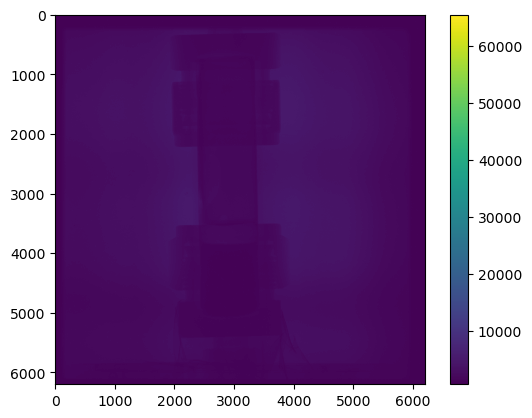

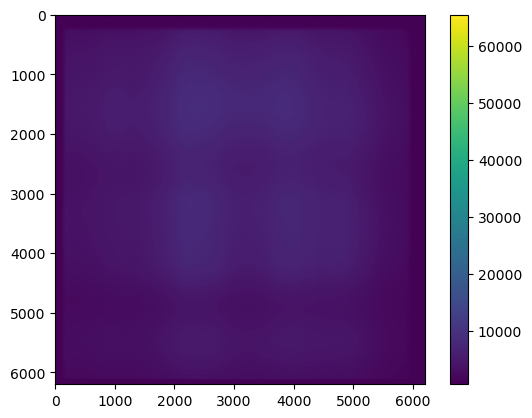

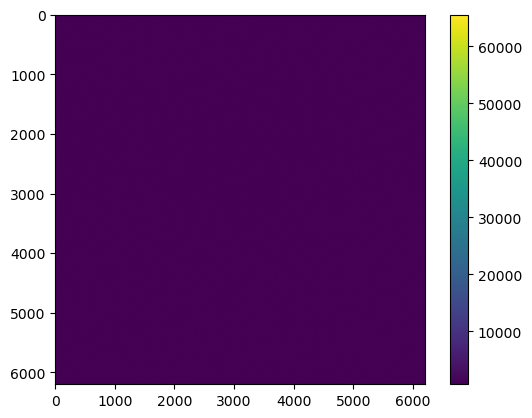

In [119]:
scan_min = np.min(scan_raw, axis=0)
ob_min = np.min(ob_raw, axis=0)
dc_max = np.max(dc_raw, axis=0)
plt.imshow(scan_min)
plt.colorbar()
plt.show()
plt.imshow(ob_min)
plt.colorbar()
plt.show()
plt.imshow(dc_max)
plt.colorbar()
plt.show()

# Crop ROI

Recon ROI:


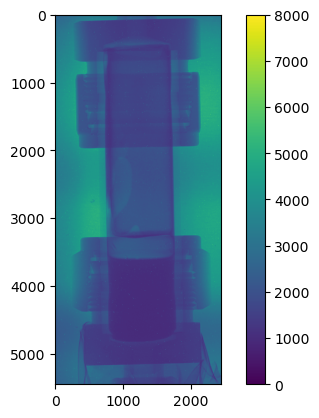

In [120]:
###################### need to change start
crop = True
# crop = False
crop_left = 1650#320
crop_right = 4100#1080
crop_top = 250
crop_bottom = -500
# crop_left = 2500
# crop_right = 4500
# crop_top = 200
# crop_bottom = 2350
###################### need to change end
scan_crop = rocku.crop(scan_raw, crop_left, crop_right, crop_top, crop_bottom, crop)
ob_crop = rocku.crop(ob_raw, crop_left, crop_right, crop_top, crop_bottom, crop)
dc_crop = rocku.crop(dc_raw, crop_left, crop_right, crop_top, crop_bottom, crop)
scan_crop_min = rocku.crop(scan_min, crop_left, crop_right, crop_top, crop_bottom, crop)
print("Recon ROI:")
plt.imshow(scan_crop_min, vmin=0, vmax=8000)
plt.colorbar()
plt.show()

# Removal outliers

In [121]:
t0 = timeit.default_timer()
scan_crop = tomopy.misc.corr.remove_outlier_cuda(scan_crop, gamma_diff).astype(np.ushort)
ob_crop = tomopy.misc.corr.remove_outlier_cuda(ob_crop, gamma_diff).astype(np.ushort)
dc_crop = tomopy.misc.corr.remove_outlier_cuda(dc_crop, gamma_diff).astype(np.ushort)
t1 = timeit.default_timer()
print("Time: {} s".format(t1-t0))

Time: 9.674167577177286 s


# Bin images

In [122]:
bin_size = 1
#####################
#####################
if bin_size != 1:
    to_rmv = len(fname_list)%bin_size
    if to_rmv == 0:
        fname_list_rmv = fname_list[:]
        scan_crop_rmv = scan_crop[:]
    else:
        fname_list_rmv = fname_list[:-to_rmv]
        scan_crop_rmv = scan_crop[:-to_rmv]
    fname_list_bin = fname_list_rmv[0::bin_size]
    scan_crop_bin = np.array([np.mean(scan_crop_rmv[i:i+bin_size], axis=0) for i in tqdm(range(0, len(scan_crop_rmv), bin_size))]) 

# Normalization

OB stack combined by median.
DC stack combined by median.
Normalization Done!
float32
(129, 5450, 2450)


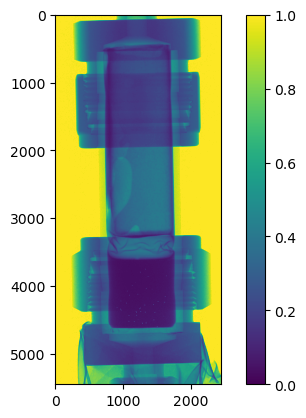

In [123]:
#####################
#####################
if bin_size != 1:
    scan_norm, scan_mi_dc, ob_mi_dc, dc_med = rocku.normalize(scan_crop_bin, ob_crop, dc_crop)
else:
    scan_norm, scan_mi_dc, ob_mi_dc, dc_med = rocku.normalize(scan_crop, ob_crop, dc_crop)
print(scan_norm.dtype)
print(scan_norm.shape)
plt.imshow(scan_norm[0], vmin=0, vmax=1)
# plt.imshow(scan_norm[0])
plt.colorbar()
plt.show()

# Check if OB has changed

In [124]:
# reg_ob = True
reg_ob = False
reg_left = 100#320
reg_right = -100#1080
reg_top = 900
reg_bottom = 1200
###################### need to change end
if reg_ob:
    scan_norm_unreg_roi = rocku.crop(scan_norm, reg_left, reg_right, reg_top, reg_bottom, reg_ob)
    scan_unreg_roi = rocku.crop(scan_mi_dc, reg_left, reg_right, reg_top, reg_bottom, reg_ob)
    ob_unreg_roi = rocku.crop(ob_mi_dc, reg_left, reg_right, reg_top, reg_bottom, reg_ob)
    
    f, ax = plt.subplots(1, 2, figsize=(20, 20))
    ax[0].imshow(scan_norm_unreg_roi[0])
    ax[0].set_title('first image')
    
    ax[1].imshow(scan_norm_unreg_roi[-1])
    ax[1].set_title('last image')

In [125]:
if reg_ob:
    trans_algo_dict = {
        'TRANSLATION': StackReg.TRANSLATION,
        'RIGID_BODY': StackReg.RIGID_BODY,
        'SCALED_ROTATION': StackReg.SCALED_ROTATION,
        'AFFINE': StackReg.AFFINE,
        'BILINEAR': StackReg.BILINEAR
    }
    trans_algo = "RIGID_BODY"
    #########################
    #load reference and "moved" image
    ref = scan_unreg_roi[0]
    mov = ob_unreg_roi
    #########################
    sr = StackReg(trans_algo_dict[trans_algo])
    reg = sr.register_transform(ref, mov)
    # reg = reg.clip(min=0)
    
    f, ax = plt.subplots(1, 2, figsize=(20, 20))
    
    ax[0].imshow(scan_norm_unreg_roi[0])
    ax[0].set_title('Empty area before registering OB')
    ax[0].axis('off')
    
    ax[1].imshow(np.true_divide(ref, reg, dtype=np.float32))
    ax[1].set_title('Empty area after registering OB')
    ax[1].axis('off')

In [126]:
# Apply registration to full OB
if reg_ob:
    ob_mi_dc_reg = sr.transform(ob_mi_dc)
    scan_norm_reg = np.true_divide(scan_mi_dc, ob_mi_dc_reg, dtype=np.float32)
    f, ax = plt.subplots(1, 2, figsize=(20, 20))
    
    ax[0].imshow(scan_norm[0])
    ax[0].set_title('Before registering OB')
    ax[0].axis('off')
    
    ax[1].imshow(scan_norm_reg[0])
    ax[1].set_title('After registering OB')
    ax[1].axis('off')
else:
    scan_norm_reg = scan_norm[:]

# Beam fluctuation correction (optional)


Beam fluctuation ROI:


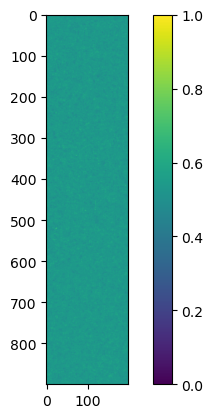

In [127]:
###################### need to change start
fluc_corr = True
# fluc_corr = False
bg_left = 0
bg_right = 200
bg_top = 2100
bg_bottom = 3000
###################### need to change end
if fluc_corr:
    bg_stack = scan_norm_reg[:, bg_top:bg_bottom, bg_left:bg_right]
    bg_min = np.min(bg_stack, axis=0)
    print("Beam fluctuation ROI:")
    plt.imshow(bg_min, vmin=0, vmax=1)
    plt.colorbar()
    plt.show()

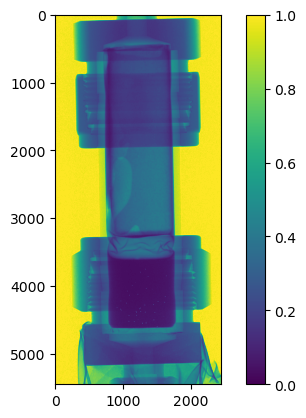

Time: 11.01356859691441 s


In [128]:
if fluc_corr:
    t0 = timeit.default_timer()
    scan_norm_reg = tomopy.prep.normalize.normalize_roi(scan_norm_reg, roi= [bg_top, bg_left, bg_bottom, bg_right], ncore=ncore)
    plt.imshow(scan_norm_reg[0], vmin=0, vmax=1)
    plt.colorbar()
    plt.show()
    t1 = timeit.default_timer()
    print("Time: {} s".format(t1-t0))

# Crop output

Output ROI:


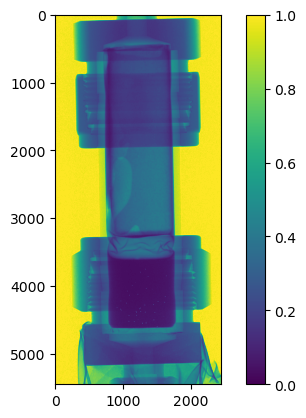

In [129]:
###################### need to change start
# out_crop = True
out_crop = False
out_crop_left = 0#320
out_crop_right = 800#1080
out_crop_top = 0
out_crop_bottom = -1
###################### need to change end
scan_norm_out = rocku.crop(scan_norm_reg, out_crop_left, out_crop_right, out_crop_top, out_crop_bottom, out_crop)
print("Output ROI:")
plt.imshow(scan_norm_out[0], vmin=0, vmax=1)
plt.colorbar()
plt.show()

Time: 5.262743843719363 s


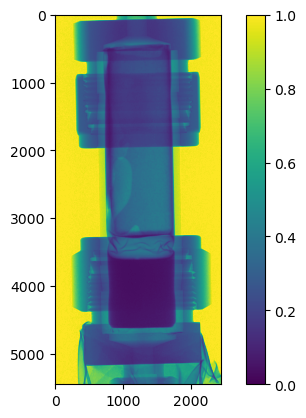

In [130]:
t0 = timeit.default_timer()
scan_norm_out = tomopy.misc.corr.remove_outlier_cuda(scan_norm_out, 0.1) 
t1 = timeit.default_timer() 
print("Time: {} s".format(t1-t0))
plt.imshow(scan_norm_out[0], vmin=0, vmax=1)
plt.colorbar()
plt.show()

# Save files

In [131]:
################ change save path for your own
save_to = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/normalized/" + sample_name# + '_Right'
if bin_size != 1:
    save_to = save_to + "_binned_by_" + str(bin_size)
    fname_list_save = fname_list_bin[:]
else:
    fname_list_save = fname_list[:]
print('Saving to {} ...'.format(save_to))
for i, e_name in tqdm(enumerate(fname_list_save)):
#     e_name = rocku.remove_1st_str(e_name)
    fname = save_to + "/" + e_name
    dxchange.write_tiff(scan_norm_out[i], fname=fname, overwrite=True)

Saving to /HFIR/CG1D/IPTS-33285/shared/processed_data/normalized/2024_09_26_AG1_2 ...


129it [00:15,  8.18it/s]
